In [1]:
import numpy as np
import math
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import copy

In [104]:
class LinUCB():
    def __init__(self, arm, dim=2, lamda = 1, T=1000):
        self.arm = arm
        self.A_t = 0
        self.y = np.zeros((dim, 1))
        self.V = lamda * np.identity(dim)
        self.lamda = lamda
        self.beta =  1 + np.sqrt(2*np.log(T)+dim*np.log((dim+T)/dim))
        self.actions = []
        self.T = T
        self.dim = dim
        self.action_idxs = []
        self.Vs = [copy.deepcopy(self.V)]
    def observe_reward(self, reward):
        
        self.V = self.V + self.arm[self.A_t].T * self.arm[self.A_t]
        self.Vs.append(copy.deepcopy(self.V))
        self.y = self.y + self.arm[self.A_t].T * reward
        
        
    def compute(self):
        # estimate theta 
        inv_V = np.linalg.inv(self.V)
        self.hat_theta = inv_V * self.y
        # compute ucb
        ucb = self.arm * self.hat_theta + self.beta * np.matrix(np.diag(np.sqrt( self.arm * inv_V * self.arm.T ))).T
        self.A_t = np.argmax(ucb)
        self.actions.append(self.arm[self.A_t])
        self.action_idxs.append(self.A_t)
        return self.arm[self.A_t]

In [26]:
class UCB:
    def __init__(self, action_set, dim=2, T=1000):
        self.arm = action_set
        self.T = T
        self.alpha = 1/(T**2)
        self.sample_means = np.asarray([0.0] * len(action_set))
        self.confidence_widths = np.asarray([np.inf] * len(action_set))
        self.num_pulls = np.asarray([0] * len(action_set))
        self.actions = []
        self.action_idxs = []
        self.counter = 0
        self.debug_mean = {}
        self.debug_cw = {}
        self.debug_np = {}
        
    def compute(self):
        
        if self.counter < len(action_set):
            index = self.counter
        else:
            index = np.argmax(self.sample_means + self.confidence_widths)
        
        self.debug_mean[self.counter] = copy.deepcopy(self.sample_means)
        self.debug_cw[self.counter] = copy.deepcopy(self.confidence_widths)
        self.debug_np[self.counter] = copy.deepcopy(self.num_pulls)
        self.counter += 1
        self.num_pulls[index] += 1
        
        self.action_idxs.append(index)
        self.actions.append(self.arm[index])
        return self.arm[index]
    
    def observe_reward(self, reward):
        
        cur_mean = self.sample_means[self.action_idxs[-1]]
        num_samples = self.num_pulls[self.action_idxs[-1]] - 1
        new_mean = (cur_mean * num_samples + reward)/(num_samples + 1)
        self.sample_means[self.action_idxs[-1]] = new_mean
        self.confidence_widths[self.action_idxs[-1]] = self.gcb(self.T, self.alpha, num_samples + 1)
        
    @staticmethod
    def gcb(T, alpha, num_samples):
        return np.sqrt(2*(math.pow(T, alpha) - 1)/(alpha * num_samples))
        
        
         

In [27]:
def calc_pseudoregret(theta, actions):
    diff = theta - np.max(theta)
    new_actions = np.stack(actions, axis=0)
    return -np.sum(np.dot(new_actions, theta))

In [28]:
class Oracle:
    def __init__(self, theta, upper=1, lower=0):
        self.theta = theta
        self.upper = upper
        self.lower = lower
        
    def compute_reward(self, action):
        mu = np.inner(action, self.theta)
        sigma = .2
        X = truncnorm((self.lower - mu) / sigma, (self.upper - mu) / sigma, loc=mu, scale=sigma)
        return X.rvs(1)[0]


In [29]:
def train_alg(alg, T, theta, oracle):
    alg.actions = [0]
    reward = oracle.compute_reward(alg.arm[0])
    alg.observe_reward(reward)
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)
        
def train_alg_UCB(alg, T, theta, oracle):
    for time in range(T):
        action = alg.compute()
        reward = oracle.compute_reward(action)
        alg.observe_reward(reward)

In [30]:
def generate_k_dim_vector(dim=2):
    full_index = random.randint(0,dim-1)
    vec = np.random.random(int(dim)) * 2 - 1
    vec[full_index] = np.sign(vec[full_index]) * 1
    return vec

def generate_random_vec(dim=2, mag=1):
    vec = np.random.random(int(dim))
    vec = vec/np.linalg.norm(vec)*mag
    return vec

In [31]:
def plot_vectors(theta, actions):
    plt.axis([-1, 1, -1, 1])
    plt.quiver(0, 0, theta[0], theta[1], color='green', scale=1)
    for idx, action in enumerate(actions):
        plt.quiver(0, 0, action[0], action[1], color = [(idx/len(actions), 0, 0)], scale=1)

In [32]:
theta = np.matrix([.5, -.25, .33, -.125, .8])
oracle = Oracle(theta)
dim = 5
alg = LinUCB(action_set, dim=dim)
train_alg(alg, T, theta, oracle)
# plot_vectors(theta, [alg.actions[-1]])
print(alg.actions[-1])
print(alg.hat_theta)

theta = np.matrix([.01, -.01, .01, -.01, .01])
oracle = Oracle(theta)
alg = LinUCB(action_set, dim=dim)
train_alg(alg, T, theta, oracle)
print(alg.actions[-1])
print(alg.hat_theta)

ValueError: shapes (1,2) and (5,1) not aligned: 2 (dim 1) != 5 (dim 0)

AttributeError: module 'matplotlib.pyplot' has no attribute 'quiv'

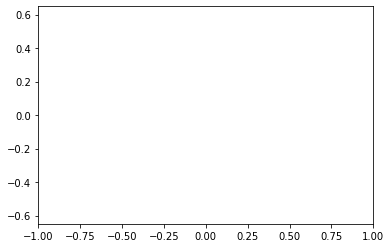

In [33]:
x = np.linspace(0,1,11)
y = np.linspace(1,0,11)
u = v = np.zeros((11,11))
u[5,5] = 0.2
plt.axis('equal')
plt.axis([-1, 1, -1, 1])
plt.quiv
er(0,0, .8, -.33,  color=[(.5, 0, 0)], scale=1)

In [34]:
#Change action set to boundaries
#Check how two thetas with same optimal actions will have different action sequences
#Why are these different? How will these differ?
#Choose different colors and figure out the scale
#check about frequency of "pulls", sum the action sequence!
#Candidate values of theta: alternating signs (like with 0.9, 0.5 as values, a lot of coordinates should differ), alternating signs with only one coord differs
#Exploratory: If you were just solving mab, can you formulat an alternative estimator that is a solution to an lp
#Exploratory: decision variables are unknown means where you have to solve, and every time an arm is pulled, you get a constraint
# You also get other constraints that when an arm is not pulled, you get an equality constraint
#so look at the end of the horizon, and get the lp from there

In [46]:
theta = np.matrix(generate_random_vec(dim = 2))
action_set = np.matrix([generate_random_vec(dim = 2) for _ in range(10)])
oracle = Oracle(theta)
T=10000
alg = UCB(action_set, T=T, dim=2)

alpha = 1/(T * T)
train_alg_UCB(alg, T, theta, oracle)
# print(alg.action_idxs)
rewards = action_set @ theta.T
min_reward = min(rewards)
max_reward = max(rewards)

In [105]:
import gurobipy as gp

def estimate_ucb_means_lp(alg):
    m = gp.Model()
    all_vars = {}
    num_pulls = {}
    T = alg.T
    for i in range(len(action_set)):
        num_pulls[i] = []

    for t in range(T):
        for key in num_pulls.keys():
            if alg.action_idxs[t] != key:
                if t != 0:
                    num_pulls[key].append(num_pulls[key][ - 1])
                else:
                    num_pulls[key].append(0)
            else:
                if t != 0:
                    num_pulls[key].append(num_pulls[key][ - 1] + 1)
                else:
                    num_pulls[key].append(1)

    for t in range(T):
        for idx, ele in enumerate(action_set):
            if t not in all_vars:
                all_vars[t] = {}
            all_vars[t][idx] = m.addVar(name="u_{}_{}".format(t, idx))

    expr = gp.LinExpr()
    list_of_all_vars = []
    for t in range(T-1,T):
        for i in range(len(action_set)):
            list_of_all_vars.append(all_vars[t][i])

    
    expr.addTerms([1.0] * len(list_of_all_vars), list_of_all_vars)

    m.setObjective(expr, gp.GRB.MAXIMIZE)



    for t, ele in enumerate(alg.action_idxs):
        for i in range(len(action_set)):
            if i != ele and t >= len(action_set):
                m.addConstr(all_vars[t][ele] + UCB.gcb(T, alpha, num_pulls[ele][t-1]) - all_vars[t][i] - UCB.gcb(T, alpha, num_pulls[i][t - 1]) >= 0)
                if t + 1 < T:
                    m.addConstr(all_vars[t + 1][i] - all_vars[t][i] == 0)
            m.addConstr(all_vars[t][i] >= 0)
            m.addConstr(all_vars[t][i] <= 1)



    m.optimize()
    lp_vals = []
    for i in range(len(action_set)):
        lp_vals.append(all_vars[T-1][i].X)
        
    return lp_vals

lp_vals = estimate_ucb_means_lp(alg)

ZeroDivisionError: float division by zero

In [ ]:
true_rewards = rewards = action_set @ theta.T
best_true = max(true_rewards)
best_sample = max(alg.sample_means)
best_lp = max(lp_vals)

for idx in range(len(action_set)):
    print("arm {}, Real: {}, Calc: {}, LP: {}".format(idx, best_true - true_rewards[idx], best_sample - alg.sample_means[idx], best_lp - lp_vals[idx]))

In [117]:
theta = np.matrix(generate_random_vec(dim = 2))
action_set = np.matrix([generate_random_vec(dim = 2) for _ in range(100)])
oracle = Oracle(theta)
dim=2
T=1000
alg = LinUCB(action_set, dim=dim)
train_alg_UCB(alg, T, theta, oracle)

/var/folders/j0/12_hmkfx6bx04_ymlhscx4t80000gp/T/ipykernel_5879/3307304515.py:26: RuntimeWarning: invalid value encountered in sqrt
  ucb = self.arm * self.hat_theta + self.beta * np.matrix(np.diag(np.sqrt( self.arm * inv_V * self.arm.T ))).T


In [118]:
def calc_Vs(alg):
    Vs = []
    Vs.append(alg.lamda * np.identity(alg.dim))
    for t in range(T):
        Vs.append(Vs[-1] + (alg.actions[t].T * alg.actions[t]))
    return(Vs)

def estimate_linucb_means_lp(alg):
    m = gp.Model()
    all_vars = {}
    T = alg.T
    
    Vs = calc_Vs(alg)
    for t in range(T):
        all_vars[t] = []
        for i in range(dim):
            all_vars[t].append(m.addVar(name="y_{}_{}".format(t, idx)))
    
    expr = gp.LinExpr()
    expr.addTerms([1.0] * len(all_vars[alg.T - 1]),all_vars[alg.T - 1])
    
    m.setObjective(expr, gp.GRB.MAXIMIZE) 
    print(alg.Vs[0])
    print(Vs[0])
    print(alg.Vs[10])
    print(Vs[10])
    print(alg.Vs[20])
    print(Vs[20])
    for t in range(T):
        for action in action_set:
            V = Vs[t]
            invV = np.linalg.inv(V)
            if action is not alg.actions[t]:
                expr = gp.LinExpr()
                
                mult = np.asarray(action @ invV)[0] * -1
                expr.addTerms(mult, all_vars[t])
                constant = np.sqrt(action @ invV @ action.T) * alg.beta * -1
                expr.addConstant(constant)
                          
                opt_mult = np.asarray(alg.actions[t] @ invV)[0]
                expr.addTerms(opt_mult, all_vars[t])
                opt_constant = np.sqrt(alg.actions[t] @ invV @ alg.actions[t].T) * alg.beta
                expr.addConstant(opt_constant)
                
                m.addConstr(expr >= 0)
    
    for i in range(alg.dim):
        m.addConstr(all_vars[0][i] == 0)
                
                
    
    for i in range(alg.dim):
        for t in range(alg.T):
            if t + 1 < alg.T:
                m.addConstr(all_vars[t][i] + 1 >= all_vars[t + 1][i])
                m.addConstr(all_vars[t][i] <= all_vars[t+1][i])

    m.optimize()
            
    final_Vinv = np.linalg.inv(Vs[-1])
    final_y = np.matrix([ele.X for ele in all_vars[alg.T - 1]]).T
    
    print(final_Vinv.shape)
    print(final_y.shape)
    
    theta_estimate = np.linalg.inv(Vs[-1]) @ np.matrix(final_y)
    return theta_estimate
            
    
    
    
                
theta_estimate = estimate_linucb_means_lp(alg)
            

[[1. 0.]
 [0. 1.]]
[[1. 0.]
 [0. 1.]]
[[5.29756458 1.18553604]
 [1.18553604 6.70243542]]
[[5.29756458 1.18553604]
 [1.18553604 6.70243542]]
[[ 9.00758562  2.76852961]
 [ 2.76852961 12.99241438]]
[[ 9.00758562  2.76852961]
 [ 2.76852961 12.99241438]]
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[x86])
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 103998 rows, 2000 columns and 205994 nonzeros
Model fingerprint: 0xc8b4ccf9
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-16, 1e+00]

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Presolve removed 3277 rows and 3 columns
Presolve removed 3 rows and 5752 columns
Presolve time: 0.48s
Presolved: 1997 rows, 98246 columns, 196490 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.994e+03
 Factor NZ  : 3.385e+04 (roughly 4

In [116]:
print(theta_estimate/np.linalg.norm(theta_estimate))
print(theta/np.linalg.norm(theta))

[[0.76726492]
 [0.64133029]]
[[0.77895816 0.62707591]]
